# Restricted Boltzmann Machine

https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf

Deep learning by ian goodfellow, yoshua bengio and aaron courville.


Like the general Boltzmann machine, the restricted Boltzmann machine is an energy-based model with the joint probablity distribution specified by its energy function.

$$ p(v,h) = \frac{1}{Z} exp( -E(v,h)) $$

The energy function for the RBM is given by

$$ E(v,h) = -b^Tv - c^Th - v^TWh $$

where, v:visible features; h:hidden features

Z is the normalizing constant known as the partition function
$$Z = \sum_{v}\sum_{h}exp(-E(x,h))$$


The free energy function is given as,

$$F(x) = -log \sum_h exp({-E(x,h)})$$

The positive phase and the negative phase is.

$$ E(v,h) = -b^Tv - c^Th - v^TWh  = -\sum_k b_kv_k - \sum_j c_jh_j - \sum_j\sum_k W_{jk}h_jv_k$$

To maximize the probability v,c and h should be between 0 and 1 in the above equation.
If $W_{jk}$ is negative then either h or v  should be 0 or both has to be 0.
If $W_{jk}$ is positive then both  h and v term should to be 1.

The negative log-likelihood gradient is given as.

$$- \frac{\partial  \log p(x)}{\partial \theta} = \frac{\partial \mathcal{F}(x)}{\partial \theta} -\sum_{\tilde{x}}p(\tilde{x}) \frac{\partial \mathcal{F}(\tilde{x})}{\partial \theta}$$




Though P(v) is intracable, the bipartite graph structure of the RBM has the special property of it's conditional distribution P(h|v) and P(v|h) being factorial and relatively easy to compute.

$$P(h|v) = \frac{P(h,v)}{P(v)}$$
Using gibbs sampling for sampling the data
We use Gibbs sampling for this purpose

$p(h|v) = \prod_j p(h_j|v)$

$p(v|h) = \prod_k p(v_k|h)$

Since we want h and v to be between 0 and 1 we normalize the distribution over the individual binary $h_j$. 

$$P(h_j = 1|v) = sigm (c_j + v^TW_j)$$

$$P(v_k = 1|h) = sigm (b_k + W^Tv)$$

For a binary unit, the probability of turning on is given by the logistic sigmoid function of its total
input, x.

$$p=sigm(x)= \frac{1}{1+e^{−x}}$$

For RBM, the corresponding pseudo log-likelihood formula is:

$$log PL(v)≈ N*log(sigmoid(FE(v_i)−FE(v)))$$

where $v_i$ is the same visible units configuration as v except the i-th unit is flipped(0->1, 1->0).

In [ ]:
import tensorflow as tf
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import random
import copy
from tensorflow.examples.tutorials.mnist import input_data

In [ ]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [ ]:
k = tf.constant(1)
ct = tf.constant(1)    
size_x = 28*28
size_bt = 64 # batch size

In [ ]:
def scale_unit(imsh, epsi=1e-8):
    imsh = imsh.copy()
    imsh -= imsh.min()
    imsh *= 1.0 / (imsh.max() + epsi)
    return imsh

In [ ]:
def sample(probs):
    return tf.to_float(tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1)))

In [ ]:
def scale(X, shape_in, ts, im_spcing=(0, 0),unit_int_scale=True,op_pvals=True):
    opshape = [(ishp + tsp) * tshp - tsp
               for ishp, tshp, tsp in zip(shape_in, ts, im_spcing)
    ]
    L, B = shape_in
    Ls, Bs = im_spcing
    dt = X.dtype
    if op_pvals:
        dt = 'uint8'
    scaled_ary = np.zeros(opshape, dtype=dt)

    for tile_row in range(ts[0]):
        for tile_col in range(ts[1]):
            if tile_row * ts[1] + tile_col < X.shape[0]:
                this_x = X[tile_row * ts[1] + tile_col]
                if unit_int_scale:
                    tempimg = scale_unit(
                        this_x.reshape(shape_in))
                c = 1
                if op_pvals:
                    c = 255
                scaled_ary[
                    tile_row * (L + Ls): tile_row * (L + Ls) + L,
                    tile_col * (B + Bs): tile_col * (B + Bs) + B
                ] = tempimg * c
    return scaled_ary

In [ ]:
##function to remove pixels
def removePixels(dataset, ratio):
    max_count = int(784*(ratio/100))
    rindex = random.sample(range(0, 783), max_count)
    for i in range(len(dataset)):        
        for j in rindex:
            dataset[i][j] = 0
            
    return dataset

In [ ]:
remove_20 = copy.deepcopy(mnist.test)
removePixels(remove_20.images, 20)
remove_50 = copy.deepcopy(mnist.test)
removePixels(remove_50.images, 50)
remove_80 = copy.deepcopy(mnist.test)
removePixels(remove_80.images, 80)

In [ ]:
def sampleInt(probs):
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))

In [ ]:
def gibbs(xx, hh, count, k):
    g1 = sampleInt(tf.sigmoid(tf.matmul(W, hh) + tf.tile(c, [1, size_bt])))
    h1 = sampleInt(tf.sigmoid(tf.matmul(tf.transpose(W), g1) + tf.tile(b, [1, size_bt])))
    return g1, h1, count+1, k

def k_check(xk, hk, count, k):
    return count <= k

In [ ]:
hid_n = 500
hidden_bia = tf.Variable(tf.random_uniform([hid_n, 1], -0.005, 0.005))
visi_bia = tf.Variable(tf.random_uniform([size_x, 1], -0.005, 0.005))    
W_v = tf.Variable(tf.random_uniform([size_x, hid_n], -0.005, 0.005))
momentum = tf.placeholder(tf.float32, [size_x, size_bt])
sig_act = sample(tf.sigmoid(tf.matmul(tf.transpose(W_v), momentum) + tf.tile(hidden_bia, [1, size_bt])))
a = tf.placeholder(tf.float32)
[xk1, hk1, _, _] = tf.while_loop(k_check, gibbs, [momentum, sig_act, ct, k])
W_v_ = tf.multiply(a/float(size_bt), tf.subtract(tf.matmul(momentum, tf.transpose(sig_act)), tf.matmul(xk1, tf.transpose(hk1))))
hidden_bia_ = tf.multiply(a/float(size_bt), tf.reduce_sum(tf.subtract(sig_act, hk1), 1, True))
visi_bia_ = tf.multiply(a/float(size_bt), tf.reduce_sum(tf.subtract(momentum, xk1), 1, True))

w_o = [W_v.assign_add(W_v_), hidden_bia.assign_add(hidden_bia_), visi_bia.assign_add(visi_bia_)]

In [ ]:
def RBM(w_o, data):
    
    # run session
    serbm = tf.Session()
    init = tf.initialize_all_variables()
    serbm.run(init)
    
    tr_x = np.zeros((28,28))
    
    for i in range(1, 1000):
        tr_x, tr_y  = data.next_batch(size_bt)
        tr_x = np.transpose(tr_x)
        tr_y = np.transpose(tr_y)
        alpha = min(0.05, 100/float(i))
        serbm.run(w_o, feed_dict={momentum: tr_x, a: alpha})
    
    image_gen = scale(np.transpose(tr_x), shape_in=(28, 28), ts=(2, 4),im_spcing=(3, 3))
    imagex = Image.fromarray(image_gen)
    plt.imshow((imagex))
    plt.show()

Training


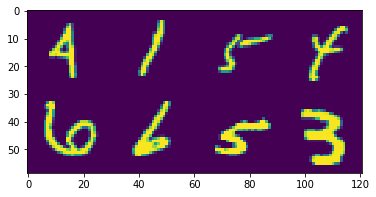

In [ ]:
print("Training")
RBM(w_o, mnist.train)

Test data


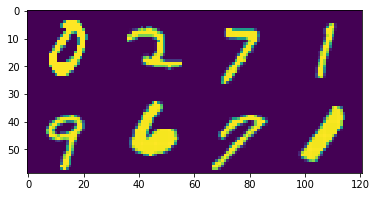

In [ ]:
print("Test data")
RBM(w_o, mnist.test)

20% missing/removed pixels in the testing data


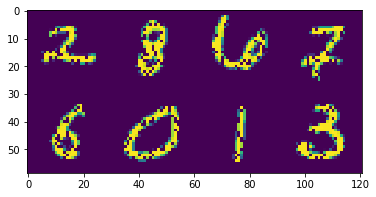

In [ ]:
print("20% missing/removed pixels in the testing data")
RBM(w_o, remove_20)

50% missing/removed pixels in the testing data


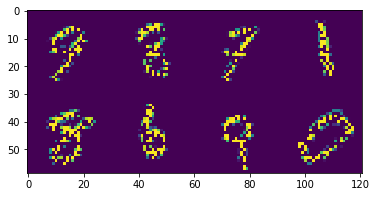

In [ ]:
print("50% missing/removed pixels in the testing data")
RBM(w_o, remove_50)

80% missing/removed pixels in the testing data


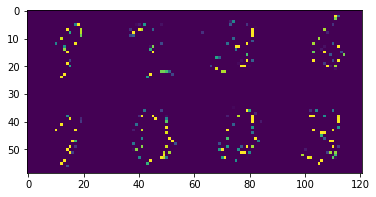

In [ ]:
print("80% missing/removed pixels in the testing data")
RBM(w_o, remove_80)

#  Variational Autoencoder (VAE)

derivation: Prof. Ali Ghodsi, Lec : Deep Learning, Variational Autoencoder

https://keras.io/examples/variational_autoencoder/

KL divergence which gives the similarities between 2 different distribution p and q can be written as,
By definition of KL Divergence: 
$$KL(p||q) = -\sum q(x) logq(x) + \sum p(x)log p(x) $$

Since p is given with respect to q, the above equation can be written as
$$KL(p||q) = -\sum p(x) logq(x) + \sum p(x)log p(x) $$

Simplifying the above equation we get,
$$KL(p||q) = -\sum p(x) log\frac{q(x)}{p(x)}$$

Since we want q to be close to p, we minimize the KL-divegence i.e,the difference of the distributions
$$min KL(q(z)||p(z|x)) = -\sum q(z)log \frac{p(z|x)}{q(z)}    ---eqn(1)$$

To infer p(z|x) using q(z|x)
$$p(z|x) = \frac {p(x|z)p(z)}{p(x)}  ---eqn(2)$$ 

where, 
$$p(x)=\int p(x|z)p(z)dz$$

substituting eqn(2) in equation 1 and simplying, we get
$$ = -\sum q(z) \big[log\frac{p(x,z)}{q(z)}-log p(x)\big]$$

The above equation can be written as,
So, we can write the above as:

$$ log p(x) = KL(q(z) || p(z|x)) + \sum q(z) log\frac{p(x,z)}{q(z)} $$

where,
$\mathcal{L} = \sum q(z) log\frac{p(x,z)}{q(z)}$

since variational lower bound $\mathcal{L} <=log p(x)$ 

Maximizing the lower bound term will be equal to minimizing the KL term, maximizes the observation

from defnition,

$$\mathcal{L} = \sum q(z) log\frac {p(x|z)p(z)}{q(x)}$$

simplifying we get,
$$\mathcal{L} = \sum q(z) logp(x|z) + \sum q(z)log\frac{p(z)}{q(z)}$$

where,
expectation $E_{q(z)}p(x|z)$

The lower bound equation can be rewritten in term of expectation as,

$$\mathcal{L} =  E_{q(z)} p(x|z) - KL(q(z)||p(z))$$

we can write this in gaussian form as
$$ min(|x-\hat{x}|^2  + KL(q(z|x)||N(\mu,\sigma^2) $$

The above derrivation with q as encoder and p as decoder is implemented below 

In [ ]:
from __future__ import absolute_import  
from __future__ import division   
from __future__ import print_function

from keras.layers import Dense, Lambda, Input
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

# 2 code units

In [ ]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [ ]:
image_size = 28
original_dim = image_size * image_size
input_shape = (original_dim, )
hidden_l = 256
batch_size = 128
code_unit = 2 
epochs = 5
epsilon_std = 1.0

In [ ]:
##same for the this and the 3rd question
def sampling(var):
    meanz, temp = var
    epsilon = K.random_normal(shape = (K.shape(meanz)[0], latent_dim), mean = 0., stddev = epsilon_std)
    samp = meanz + K.exp(0.5 * temp) * epsilon
    return samp

In [ ]:
##same for this and 3rd question
def plot_r(unit_size,models,d,batch_size=128):
    encoder = models[0]
    decoder = models[1]
    n = 30
    gridxy = np.zeros((28 * n, 28 * n))
# as per the question 
    gridx = np.linspace(-3, 3, n)
    gridy = np.linspace(-3, 3, n)
    
    for i, variance in enumerate(gridy):
        for j, means in enumerate(gridx):
            if unit_size == 1:
                zample = np.array([[means,variance]*unit_size])
            else:
                zample = np.random.normal(0,1,size = [batch_size,unit_size*2])
            dec_x = decoder.predict(zample)
            digit = dec_x[0].reshape(28, 28)
            gridxy[i * 28: (i + 1) * 28,
                   j * 28: (j + 1) * 28] = digit    
    plt.figure(figsize=(10, 10))
    start_r = 28 // 2
    end_r = (n - 1) * 28 + start_r + 1
    tr_val = np.arange(start_r, end_r, 28)
    r_x = np.round(gridx, 1)
    r_y = np.round(gridy, 1)
    plt.xticks(tr_val, r_x)
    plt.yticks(tr_val, r_y)
    plt.imshow(gridxy)
    plt.show()

In [ ]:
## creating encoder model
inputs = Input(shape=input_shape)
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z])

##creating decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs)

In [ ]:
##VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
models = (encoder, decoder)
data = (x_test, y_test)
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 69s 1ms/step - loss: 179.2566 - val_loss: 141.2835
Epoch 2/5
60000/60000 [==============================] - 5s 79us/step - loss: 136.0565 - val_loss: 130.1817
Epoch 3/5
60000/60000 [==============================] - 5s 79us/step - loss: 128.5511 - val_loss: 125.4389
Epoch 4/5
60000/60000 [==============================] - 5s 79us/step - loss: 125.0027 - val_loss: 122.8360
Epoch 5/5
60000/60000 [==============================] - 5s 78us/step - loss: 122.8369 - val_loss: 121.2936


# 8 code units

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#MNIST images are of size 28x28
image_size = 28
original_dim = image_size * image_size
#Now, we flatten/unroll and normalize the images
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
input_shape = (original_dim, )
intermediate_dim = 256
batch_size = 128
latent_dim = 8  
epochs = 5
epsilon_std = 1.0
## creating encoder model
inputs = Input(shape=input_shape)
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z])

##creating decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs)

##VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
models = (encoder, decoder)
data = (x_test, y_test)
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 69s 1ms/step - loss: 175.7339 - val_loss: 140.0034
Epoch 2/5
60000/60000 [==============================] - 5s 79us/step - loss: 135.3481 - val_loss: 130.0639
Epoch 3/5
60000/60000 [==============================] - 5s 78us/step - loss: 128.7776 - val_loss: 125.9904
Epoch 4/5
60000/60000 [==============================] - 5s 79us/step - loss: 125.4451 - val_loss: 123.1546
Epoch 5/5
60000/60000 [==============================] - 5s 78us/step - loss: 123.2890 - val_loss: 121.5143


# 16 code units

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#MNIST images are of size 28x28
image_size = 28
original_dim = image_size * image_size
#Now, we flatten/unroll and normalize the images
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
input_shape = (original_dim, )


hidden_l = 256
batch_size = 128
code_unit = 16   
epochs = 5
epsilon_std = 1.0
## creating encoder model
inputs = Input(shape=input_shape)
x = Dense(hidden_l, activation='relu')(inputs)
z_mean = Dense(code_unit, name='z_mean')(x)
z_log_var = Dense(code_unit, name='z_log_var')(x)
z = Lambda(sampling, output_shape=(code_unit,), name='z')([z_mean, z_log_var])
encoder = Model(inputs, [z_mean, z_log_var, z])

##creating decoder model
unit_ip = Input(shape=(code_unit,), name='z_sampling')
x = Dense(hidden_l, activation='relu')(unit_ip)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(unit_ip, outputs)

##VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)
models = (encoder, decoder)
data = (x_test, y_test)
reconstruction_loss = binary_crossentropy(inputs,outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 70s 1ms/step - loss: 172.3413 - val_loss: 133.8724
Epoch 2/5
60000/60000 [==============================] - 5s 78us/step - loss: 127.7391 - val_loss: 121.7798
Epoch 3/5
60000/60000 [==============================] - 5s 75us/step - loss: 120.2330 - val_loss: 117.0335
Epoch 4/5
60000/60000 [==============================] - 5s 78us/step - loss: 116.3805 - val_loss: 114.0319
Epoch 5/5
60000/60000 [==============================] - 5s 79us/step - loss: 114.0227 - val_loss: 112.0152


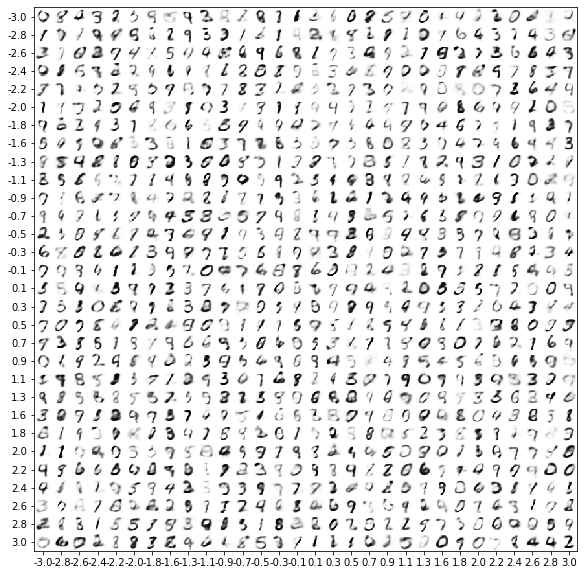

In [ ]:
plot_r(latent_dim//2, models,data, batch_size=batch_size)

#  Variational Autoencoder (VAE) CNN

https://keras.io/examples/variational_autoencoder_deconv/

https://arxiv.org/abs/1312.6114


In [ ]:
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 5

In [ ]:
# build encoder model
inputs = Input(shape=input_shape)
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,kernel_size=kernel_size,activation='relu',strides=2,padding='same')(x)
    
shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(16, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z])

In [ ]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,))
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,kernel_size=kernel_size,activation='relu',strides=2,padding='same')(x)
#     filters //= 2

outputs = Conv2DTranspose(filters=1,kernel_size=kernel_size,activation='sigmoid',padding='same')(x)

decoder = Model(latent_inputs, outputs)
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs)

/opt/anaconda3/lib/python3.6/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_52 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_52.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 115s 2ms/step - loss: 214.4411 - val_loss: 193.2132
Epoch 2/5
60000/60000 [==============================] - 43s 722us/step - loss: 190.1198 - val_loss: 186.2761
Epoch 3/5
60000/60000 [==============================] - 44s 734us/step - loss: 184.5133 - val_loss: 181.3550
Epoch 4/5
60000/60000 [==============================] - 44s 727us/step - loss: 180.6830 - val_loss: 177.9692
Epoch 5/5
60000/60000 [==============================] - 42s 699us/step - loss: 177.8015 - val_loss: 176.3325


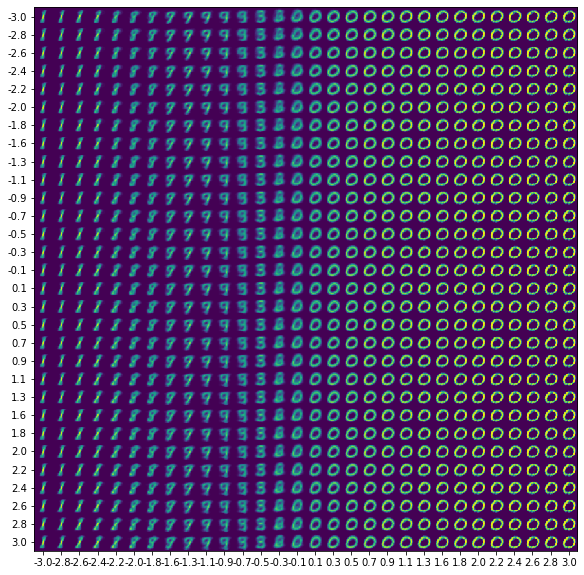

In [ ]:
models = (encoder, decoder)
data = (x_test, y_test)
reconstruction_loss = binary_crossentropy(K.flatten(inputs),K.flatten(outputs))
reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))
plot_r(latent_dim//2,models, data, batch_size=batch_size)

# Generative Adversarial Network (GAN) 

https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf

There are two neural networks in a GAN. One is called the generator which takes a random noise as input and outputs an image.The other is called the discriminator which is a binary classifier to classify whether an input image is a real image or a fake image generated by the generator.

We train D to maximize the probability of assigning the
correct label to both training examples and samples from G. We simultaneously train G to minimize
$log(1 − D(G(z))).$ In other words, D and G play the following two-player minimax game with
value function $V (G, D):$
$$\underset{G}{\text{min}}\; \underset{D}{\text{max}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

During application, the above equation may not provide sufficient gradient for G to learn well. Early in learning, when G is poor, D can reject samples with high confidence because they are clearly different from the training data. In this case, $log(1 − D(G(z)))$ saturates. Rather than training G to minimize $log(1 − D(G(z)))$ we can train G to maximize $log D(G(z))$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import Sequential, Model
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from keras.datasets import mnist

In [ ]:
(X_train,_),(_,_)=mnist.load_data()
X_train.shape

(60000, 28, 28)

In [ ]:
X_train=(X_train.astype("float32")-127.5)/127.5


In [ ]:
batch_size=256
number_batch=X_train.shape[0]//batch_size
noise_d=100

In [ ]:
##defining the generator
generator=Sequential()
generator.add(Dense(256,input_shape=(noise_d,)))
generator.add(LeakyReLU(0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(0.2))
generator.add(Dense(784,activation="tanh"))
generator.compile(loss="binary_crossentropy",optimizer=Adam(lr=2e-4,beta_1=0.5))

In [ ]:
##defining the discriminator
discriminator=Sequential()
discriminator.add(Dense(512,input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1,activation="sigmoid"))
discriminator.compile(loss="binary_crossentropy",optimizer=Adam(lr=2e-4,beta_1=0.5))

In [ ]:
# Generative Adversarial Networks
discriminator.trainable=False
gan_input=Input(shape=(noise_d,))
generate_img=generator(gan_input)
gan_output=discriminator(generate_img)
model=Model(inputs=gan_input,outputs=gan_output)
model.compile(loss="binary_crossentropy",optimizer=Adam(lr=2e-4,beta_1=0.5))

In [ ]:
X_train=X_train.reshape(-1,784)
X_train.shape

(60000, 784)

In [ ]:
def plot(epoch,no_samp=10):
    noise=np.random.normal(0,1,size=(no_samp,noise_d))
    generated_img=generator.predict(noise)
    generated_img=generated_img.reshape(-1,28,28)
    
    plt.figure(figsize=(28,28))
    for i in range(no_samp):
        plt.subplot(28,28,i+1)
        plt.imshow(generated_img[i], interpolation='nearest')
        plt.axis("off")
    plt.show()

Epoch 1 discrimanator loss 0.6931 generator loss 1.0967
Epoch 2 discrimanator loss 0.6911 generator loss 1.1021
Epoch 3 discrimanator loss 0.6917 generator loss 1.1045
Epoch 4 discrimanator loss 0.6903 generator loss 1.1038
Epoch 5 discrimanator loss 0.6899 generator loss 1.1069


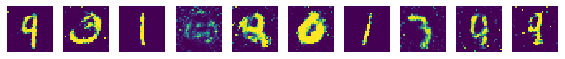

In [ ]:
loss_discr=[]
loss_gen=[]
no_batch=X_train.shape[0]//batch_size
for epoch in range(5):
    epoch_dl=0.
    epoch_gl=0.
    
    for batch in range(256):
        idx=np.random.randint(0,X_train.shape[0],128)
        r_img=X_train[idx]
        y_real=np.ones((128,1))*0.9
        noise=np.random.normal(0,1,size=(128,100))
        d_fake=generator.predict(noise)
        y_fake=np.zeros((128,1))
        
        # Training the discriminator
        real_los_data=discriminator.train_on_batch(r_img,y_real)
        fake_los_data=discriminator.train_on_batch(d_fake,y_fake)
        d_loss=0.5*fake_los_data+0.5*real_los_data
        epoch_dl+=d_loss

        # Training the Generator
        noise=np.random.normal(0,1,size=(256,100))
        truth_groundy=np.ones((256,1))
        model.train_on_batch(noise,truth_groundy)
        g_loss=model.train_on_batch(noise,truth_groundy)
        epoch_gl+=g_loss
    print("Epoch %d discrimanator loss %0.4f generator loss %0.4f"%(
    (epoch+1),epoch_dl/no_batch,epoch_gl/no_batch))
    loss_discr.append(epoch_dl)
    loss_gen.append(epoch_gl)
    if (epoch+1)%5==0:
        plot(epoch)